In [2]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import cv2 as cv
import random

In [18]:

# np . random. seed ( 0 )
N = 100
half_n = N// 2
r = 10
s = r /16
t = np . random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )



[-10.34561144  -3.73457011]


In [32]:
def RANSAC_line(Data_set,s,t,e,p):
    # s = No of points
    # t = Distance for the point from the drawn line to become inlinear
    # e = Outliar ratio
    # p = Success probability
    No_of_iterations=int(np.log(1-p)/np.log(1-(1-e)**s))

    max_inlinear_count=0
    best_fit_line_coefficient=[]

    for sample in range(0,No_of_iterations+1):
        point1,point2=random.randint(0,len(Data_set)-1),random.randint(0,len(Data_set)-1)
        #Ya + Xb + C = 0
        #Y(y1-y2)+X(x2-x1)+(x1*y2-y1*x2)=0
        a = Data_set[point1][1]-Data_set[point2][1]
        b = Data_set[point2][0]-Data_set[point1][0]
        c = Data_set[point1][0]*Data_set[point2][1] - Data_set[point1][1]*Data_set[point2][0]

        inlinear_count=0
        for i in range(0,len(Data_set)):
            distance=abs((a*Data_set[i][0] + b*Data_set[i][1]+c)/(np.sqrt(a**2+b**2)))
            if distance<t:
                inlinear_count+=1
        if inlinear_count > max_inlinear_count:
            max_inlinear_count = inlinear_count
            best_fit_line_coefficient = [a,b,c]
    
    plt.figure(figsize=(15,15))
    for data_point in Data_set:
        plt.scatter(data_point[0],data_point[1])
    x_values=np.arange(-15,15+1)
    y_values=-1*(x_values*best_fit_line_coefficient[0]+best_fit_line_coefficient[2])/best_fit_line_coefficient[1]

    plt.plot(x_values,y_values,color="red")
    plt.show()

    print("Number of Samples =",No_of_iterations)
    print("Inlinear Count =",max_inlinear_count)

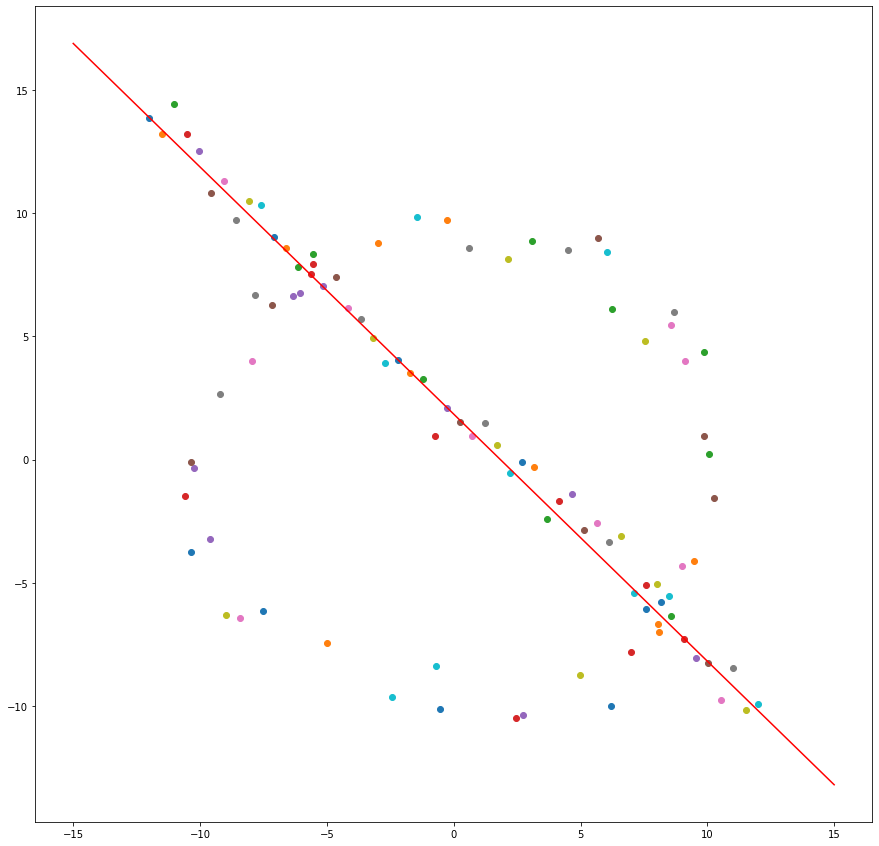

Number of Samples = 2
Inlinear Count = 55


In [43]:
RANSAC_line(X,2,1,0.1,0.99)

In [44]:
def RANSAC_circle(Data_set,No_of_iterations,t):
    max_inlinear_count=0
    best_fit_circle_coefficient=[]
    best_sample_points=[]
    
    for sample in range(0,No_of_iterations+1):
        point1,point2,point3=random.randint(0,len(Data_set)-1),random.randint(0,len(Data_set)-1),random.randint(0,len(Data_set)-1)
        x1,x2,x3=Data_set[point1][0],Data_set[point2][0],Data_set[point3][0]
        y1,y2,y3=Data_set[point1][1],Data_set[point2][1],Data_set[point3][1]

        P = np.array([[2*x1 , 2*y1 , 1] , [2*x2 , 2*y2 , 1] , [2*x3 , 2*y3 , 1]])
        if (np.linalg.det(P)==0):
            continue
        K=np.array([[x1**2 + y1**2] , [x2**2 + y2**2] , [x3**2+y3**2]])*(-1)
        answer=np.linalg.inv(P)@ K
        g,f,c=answer[0][0],answer[1][0],answer[2][0]
        radius=np.sqrt(g**2+f**2-c)
        if radius>20:
            continue
        center=[-g,-f]

        inlinear_count=0
        for i in range(0,len(Data_set)):
            distance=abs(np.sqrt((Data_set[i][0]-center[0])**2 + (Data_set[i][1]-center[1])**2) - radius)
            if distance < t:
                inlinear_count+=1
        if inlinear_count>max_inlinear_count:
            max_inlinear_count=inlinear_count
            best_fit_circle_coefficient=[g,f,c]
            best_sample_points=np.array([Data_set[point1],Data_set[point2],Data_set[point3]])
    return(best_fit_circle_coefficient,best_sample_points,max_inlinear_count)


In [45]:
s=3
t=1
e=0.5
p=0.99
No_of_iterations=int(np.log(1-p)/np.log(1-(1-e)**s))

ransac_circle_coeff,ransac_sample,ransac_inlinear_count=RANSAC_circle(X,No_of_iterations,t)

F,G,C=ransac_circle_coeff[0],ransac_circle_coeff[1],ransac_circle_coeff[2]
R=np.sqrt(G**2+F**2-C)

#Finding Inlenear and Outlinear of the RANSAC Estimated Circle
In,Out=[],[]
for point in X:
    d=abs(np.sqrt((point[0]+G)**2+(point[1]+F)**2)-R)
    if d<t:
        In.append(point)
    else:Out.append(point)

Inlin = np.array(In).T
Outlin = np.array(Out).T
Samp = ransac_sample.T

print("Number of Itarations =",No_of_iterations)
print("RANSAC Estimated circle Inlinear Count =",ransac_inlinear_count)   

Number of Itarations = 34
RANSAC Estimated circle Inlinear Count = 48


In [46]:
best_circle_coeff,best_sample,best_inlinear_count=RANSAC_circle(X,10000,t)
best_F,best_G,best_C=best_circle_coeff[0],best_circle_coeff[1],best_circle_coeff[2]
best_R=np.sqrt(best_G**2+best_F**2-best_C)

bestt_sample=best_sample.T
print("best fitting circle Inlinear Count =",best_inlinear_count)

best fitting circle Inlinear Count = 53


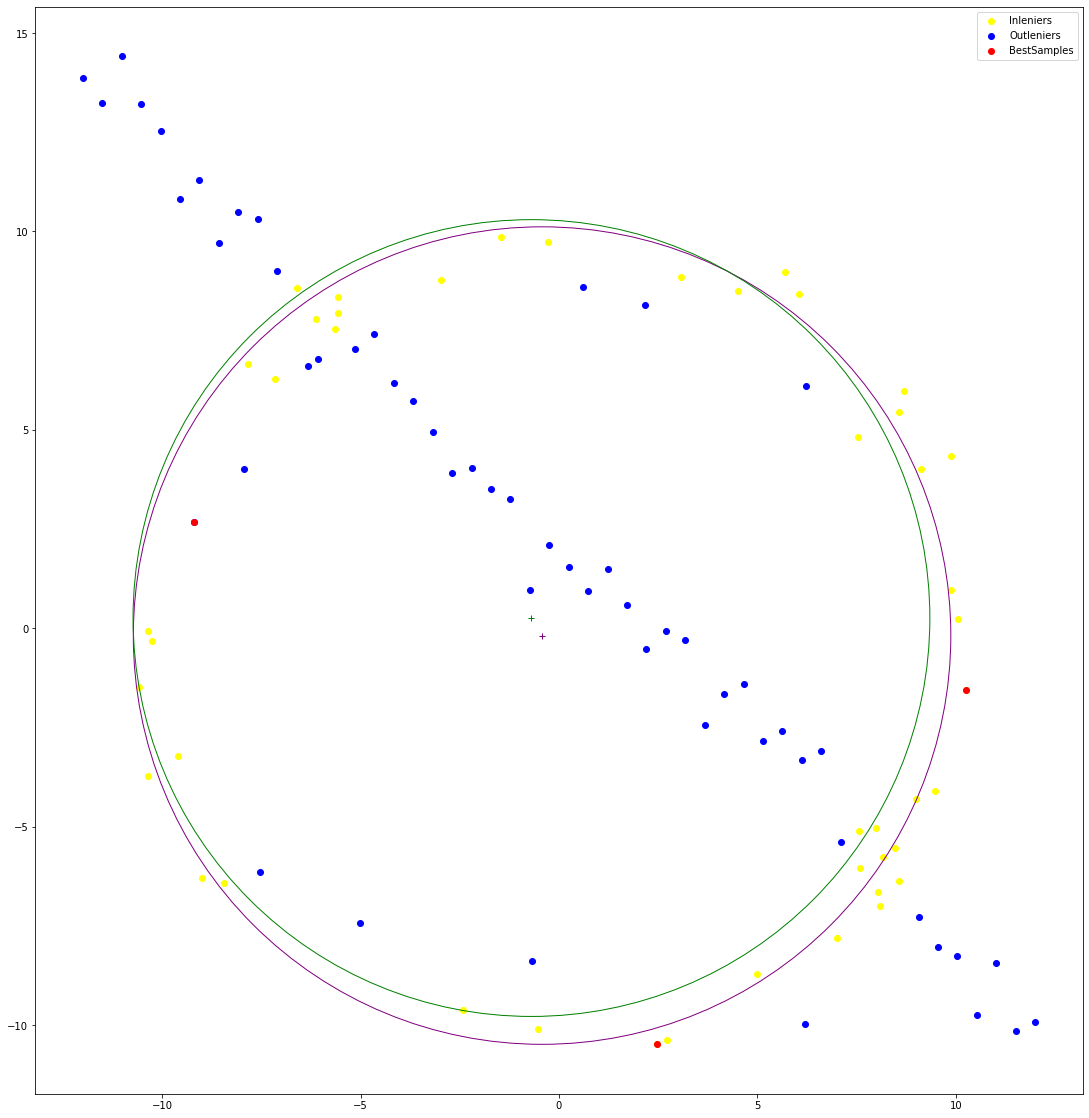

In [47]:
#plotting
figure, axes = plt.subplots( 1, figsize=(20,20) )

ransac_circle = plt.Circle((-G,-F), R, fill=False, color="purple" ,label="RANSAC")
best_fitting_circle = plt.Circle((-best_G,-best_F), best_R, fill=False, color="green" ,label="Best Fitting")

axes.scatter(Inlin[0],Inlin[1], color="yellow" , label="Inleniers")
axes.scatter(Outlin[0],Outlin[1], color="blue" , label="Outleniers")
axes.scatter(bestt_sample[0] ,bestt_sample[1], color="red" , label="BestSamples")
axes.plot(-G,-F,"+",color="purple")
axes.plot(-best_G,-best_F,"+",color="green")
axes.set_aspect( 1 )
axes.add_artist( ransac_circle )
axes.add_artist( best_fitting_circle )
#plt.legend(loc ="upper right")
plt.legend()
plt.show()

In [8]:
building = cv.imread(r'001.jpg')
flag = cv.imread(r'Flag_of_the_United_Kingdom.svg.png')

assert building is None
assert flag is None

AssertionError: 